# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [43]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

In [44]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [45]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot = 1e16 / constants.centi**2  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

  - "Gaussian" in which case width_v refers to the FWHM
  - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [50]:
N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 120  # kinetic temperature in [K]
# collider densities in m-3:
collider_densities_LTE = {
    "para-H2": 1e6 / constants.centi**3,
    "ortho-H2": 3e6 / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [ ]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)

In [73]:
def extract_values(cloud_name, data_of_molecule):
    """Extract values from the cloud object and the data file.

    Prameters:
    ----------
    cloud_name : pythonradex.radiative_transfer.Cloud
        The cloud object that contains the radiative transfer solution.
    data_of_molecule : dict
        The data file of the molecule.

    Returns:
    Tex: np.array
        The excitation temperature of the molecule.
    tau: np.array
        The optical depth of the transitions.
    Aul : np.array
        The Einstein coefficient for spontaneous emission.
    Bul : np.array
        The Einstein coefficient for stimulated emission.
    nu0_array : np.array
        The frequency of the transition in Hz.
    Eu : np.array
        The energy of the upper level in Kelvin.


    """

    # Excitation temperature
    Tex = cloud_name.Tex

    # Optical depth (tau_nu0) of the transitions
    tau = cloud_name.tau_nu0_individual_transitions

    # get Aul, Bul
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21

    # get the frequency of the transition in Hz
    nu0_array = cloud_name.emitting_molecule.nu0

    # extract atributtes from the data file
    levels = data_of_molecule["levels"]
    rad_transitions = data_of_molecule["radiative transitions"]
    coll_transitions = data_of_molecule["collisional transitions"]
    quantum_numbers = data_of_molecule["quantum numbers"]

    # This line extracts the "E" attribute from each object in levels and converts it to a NumPy array
    # and convert energies from jouls to kelvin
    Eu = np.array([level.E for level in levels]) / constants.k
    # alternative way to extract upper energy level, extracted from the radiative transitions
    # Eu_test = np.array([trans.up.E for trans in rad_transitions]) / constants.k

    # remove first component, sinze the first is nan
    Eu = Eu[1:]

    # testing
    # print("Are the the two methods the same?", np.allclose(Eu, Eu_test))

    return Tex, tau, Aul, Bul, nu0_array, Eu

In [74]:
Tex, tau, Aul, Bul, nu0_array, Eu = extract_values(cloud, data_co)
type(Tex)

numpy.ndarray

In [ ]:
def compute_flux(distance_observer, source_radius, cloud_name):
    """Computes the flux recordede by the telescope from the cloud.

    Parameters:
    ------------
    distance_observer: float
        Distance between the observer and the cloud in m.
    source_radius: float
        Radius of the cloud in m.
    cloud_name: object
        Cloud object.

    Returns:
    ------------
    Flux: np.array
        Flux recorded by the telescope in [W/m2].

    """
    # solid angle of the source
    source_solid_angle = source_radius**2 * np.pi / distance_observer**2

    # calculate the observed fluxes [W/m2], outputed as a list, set transitions to None to get all transitions
    flux = cloud_name.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

    # convert flux to np.array
    flux = np.array(flux)
    return flux


In [ ]:
# write the two above as a function, first draft


# def create_cloud(datafilepath, column_density, T_kinetic, width_v ):
#     """
#     Create a Cloud object for radiative transfer calculations.
#     Uses as defaults geometry "uniform sphere" and line profile "Gaussian".
#     For defaults no dust


#     Parameters:
#         datafilepath (str): Path to the atomic data file from LAMBDA database.
#         column_density (float): Total column density in m^-2.
#         T_kinetic (float): Kinetic temperature in K.
#         width_v (float): Line width in m/s.

#     Returns:
#         radiative_transfer.Cloud: Initialized Cloud object.
#     """
#     # Define the geometry of the nebula
#     geometry = "uniform sphere"

#     # Define the parameters of the nebula
#     line_profile_type = "Gaussian"  # line profile type

#     #no dust:
#     T_dust = 0
#     tau_dust = 0


#     # Create and return the Cloud object
#     cloud = radiative_transfer.Cloud(
#         datafilepath=datafilepath,
#         geometry=geometry,
#         line_profile_type=line_profile_type,
#         width_v=width_v,
#         N=column_density,
#         Tkin=T_kinetic,
#         collider_densities=LTE_collider_densities,
#         ext_background=ext_background,
#         T_dust=T_dust,
#         tau_dust=tau_dust
#     )

#     return cloud

In [ ]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202     120.76      0.0232358      0.0665861     0.00739182
   2    1     230.538000     120.46      0.0665861       0.101238      0.0276572
   3    2     345.795990     120.07       0.101238       0.123436      0.0556417
   4    3     461.040768     119.59       0.123436       0.131896      0.0843874
   5    4     576.267931     119.03       0.131896       0.127783       0.107386
   6    5     691.473076     118.38       0.127783       0.114098       0.120167
   7    6     806.651806     117.64       0.114098      0.0947338       0.121205
   8    7     921.799700     116.77      0.0947338      0.0735066       0.111756
   9    8    1036.912393     115.81      0.0735066       0.053459       0.095006
  10    9    1151.985452     114.66       0.053459      0.0364828      0.0749019
  11   10    1267.014486     113.53      0.0364828      0.0233878      0.0549295
  12   11    1381.995105   

‘poplow’ and ‘popup’ gives the fracitional populations of the lower and upper level respectively, and ‘tau_nu0’ the optical depth at the line centre.

## How fractional population is defined:

Column density of the lower state $N_u$
Fractional population of the lower level  $n_u$ is the proportion of particles in the lower state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

## Possible classes 
- pythonradex.atomic_transition.Level => Represents an atomic / molecular level.
- pythonradex.atomic_transition.RadiativeTransition     => Represents the radiative transition between two energy levels. 
- pythonradex.atomic_transition.EmissionLine        => Represents an emission line arising from the radiative transition between two levels (hance no absorption coeff taken into account)
- pythonradex.atomic_transition.CollisionalTransition   => Represent the collisional transition between two energy levels. 

In [ ]:
array_nu0 = cloud.emitting_molecule.nu0

In [ ]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      56.23       0.166985       0.454013       0.111165
   2    1     230.538000      11.20       0.454013       0.281867        1.34847
   3    2     345.795990      10.12       0.281867      0.0765565       0.967217
   4    3     461.040768      11.97      0.0765565      0.0155116       0.261017
   5    4     576.267931      16.86      0.0155116     0.00367598      0.0491021
   6    5     691.473076      22.56     0.00367598    0.000997868      0.0108925
   7    6     806.651806      27.43    0.000997868    0.000280757     0.00285835
   8    7     921.799700      32.18    0.000280757     8.0462e-05    0.000784673
   9    8    1036.912393      36.21     8.0462e-05    2.27524e-05    0.000222408
  10    9    1151.985452      40.16    2.27524e-05    6.34715e-06    6.22991e-05
  11   10    1267.014486      44.12    6.34715e-06    1.75215e-06    1.72368e-05
  12   11    1381.995105   

In [ ]:
# calculate the flux recorded by the telescope
# define the telescope parameters
d_observer = 100 * constants.parsec  # distance to the observer in m
source_radius = 10 * constants.au  # radius of the source in m
source_solid_angle = source_radius**2 * np.pi / d_observer**2  # solid angle of the source

# calculate the observed fluxes [W/m2], outputed as a list
flux = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux = np.array(flux)
print(flux)

[1.42876241e-24 4.14546020e-23 2.71948705e-22 9.43346801e-22
 2.26320618e-21 4.22983586e-21 6.55867600e-21 8.74650229e-21
 1.02608597e-20 1.07333380e-20 1.01259313e-20 8.66301195e-21
 6.76853950e-21 4.83852938e-21 3.16795853e-21 1.91139468e-21
 1.06224955e-21 5.45128963e-22 2.58897705e-22 1.13705137e-22
 4.62409072e-23 1.74355842e-23 6.12209829e-24 2.00753118e-24
 6.13283215e-25 1.74019868e-25 4.58292959e-26 1.12546120e-26
 2.60474746e-27 5.67864567e-28 1.15617750e-28 2.21117660e-29
 3.95738584e-30 6.71769589e-31 1.07365256e-31 1.61974958e-32
 2.29496302e-33 3.04924647e-34 3.85453514e-35 4.28024719e-36]


# Read  a file from the LAMDA database

In [ ]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


- "radiative transitions" is used for case when we are dealing with radiative transitions (spontaneous, stimulated emisions, absorption)
- "collisional transitions" is necessary for non-LTE calculations, it is a dictionary containing the transitions for each collision partner.


In [ ]:
def get_data_from_file(data_of_molecule):
    """
    Parameters:
          data_of_molecule: LAMDA_file object

    Returns:
          levels_inJoules: list of Level objects in joules
          Eu: Upper energy level in kelvin [k]
          rad_transitions: list of RadiativeTransition objects
          coll_transitions: list of CollisionalTransition objects

    """
    Eu_inJ = data_of_molecule["levels"]
    rad_transitions = data_of_molecule["radiative transitions"]
    coll_transitions = data_of_molecule["collisional transitions"]

    # convert energies from jouls to kelvin, This extracts the .E attribute from each object in levels and converts it to a NumPy array
    Eu_test = np.array([level.E for level in Eu_inJ]) / constants.k
    Eu = np.array([trans.up.E for trans in rad_transitions]) / constants.k  # upper energy level extracted from the radiative transitions

    # remove first component, sinze is the first is nan
    Eu_test = Eu_test[1:]

    # # collisional transitions
    # Eu_coll = np.array([coll_tran.up.E for coll_tran in coll_transitions]) / constants.k

    # testing
    print("Are the the two methods the same?", np.allclose(Eu, Eu_test))
    print("Upper energy of second transition in [K]:", rad_transitions[1].up.E / constants.k)
    print("Lower energy of second transition in [K]:", rad_transitions[1].low.E / constants.k)
    # print("Upper energy of second collisional transition in [K]:", coll_transitions[1].up.E / constants.k)

    return Eu_inJ, Eu, rad_transitions, coll_transitions


In [ ]:
def gamma_tau_calculator(cloud_name, colum_density_species, Aul_coeff, nu0):
    """Calculates the gamma factor for radiative transitions and the optical depth

    Parameter:
    ----------
    cloud_name:
        Cloud object
    colum_density_species:
        total column density of the species in m^-2
    Aul_coeff:
        Einstein A coefficient for the transition
    nu0:
        frequency of the transition

    Returns:
    --------
    gamma:
        gamma factors
    tau:
        optical depths
    tau_manual:
        numpy array of optical depths calculated manually

    """
    # get the optical depth
    tau = cloud.tau_nu(nu0)

    # compute upper level population density, given by: fractional population density x total column density
    # cloud.level_pop gives the fractional population density of lowes level (len 41), by removing the first element we get the fractional population density of the upper levels
    Nu = cloud.level_pop[1:] * colum_density_species

    # calculate tau manually
    Bul = cloud.emitting_molecule.B21
    tau_manual = ((constants.h * Nu * Bul) / (width_v)) * (np.exp((constants.h * nu0) / (constants.k * Tkin)) - 1)

    # calculate the gamma factor
    gamma = 8 * np.pi * constants.k * nu0**2 / (constants.h * constants.c**3 * Aul_coeff)

    # print for testing
    print("Are the the two methods the same?", np.allclose(tau, tau_manual))

    return gamma, tau, tau_manual

In [ ]:
# get relavent data from data file
levels_inJoules_co, Eu_co, rad_transitions_co, coll_transitions_co = get_data_from_file(data_co)

# compute the gamma factor for radiative transitions
gamma_factor, tau_co = gamma_tau_calculator(rad_transitions_co)

# get the y axis of the plot: ln(γ_u * W / g_u)
y_values = np.log(gamma_factor * flux / np.array([level.g for level in levels_inJoules_co])[1:])

Are the the two methods the same? True
Upper energy of second transition in [K]: 16.596176090653508
Lower energy of second transition in [K]: 5.532145167854433


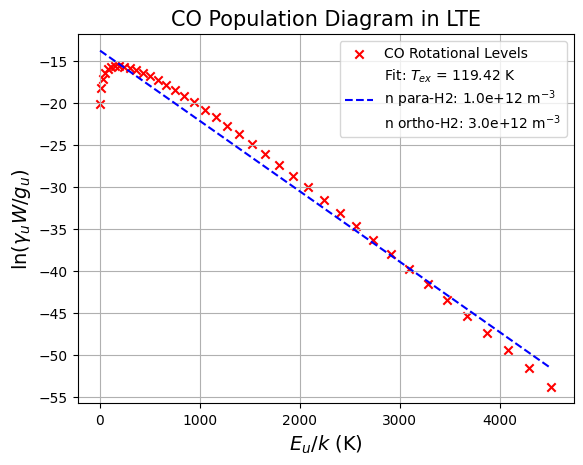

In [ ]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(Eu_co, y_values, marker="x", color="red", label="CO Rotational Levels")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(Eu_co, y_values, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(Eu_co), max(Eu_co), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {collider_densities_LTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_LTE['ortho-H2']:.1e} m$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

In [ ]:
print(f"Excitation temperature: {T_ex:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 119.42 K
kinetic temperature of the nebula: 120 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

However the y axis have the wrong sign

## Consider the escape propability SKIP THIS SECTION IS FOR TESTING
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

In [ ]:
def beta_tau_test(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    if tau_nu.any() == 0:
        return np.inf  # Avoid division by zero
    return (3 / (2 * tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


In [ ]:
# get optical depth
tau_nu = cloud.tau_nu(nu=array_nu0)
tau_nu

array([7.39182318e-03, 2.76572026e-02, 5.56416588e-02, 8.43873698e-02,
       1.07386132e-01, 1.20167069e-01, 1.21204523e-01, 1.11756237e-01,
       9.50059519e-02, 7.49019437e-02, 5.49294931e-02, 3.75006571e-02,
       2.38855203e-02, 1.42655637e-02, 7.95602796e-03, 4.12514667e-03,
       2.00302903e-03, 9.07099841e-04, 3.83258461e-04, 1.51447260e-04,
       5.58208613e-05, 1.91782738e-05, 6.15459607e-06, 1.84644706e-06,
       5.21167839e-07, 1.37969707e-07, 3.41092052e-08, 7.85902676e-09,
       1.68859308e-09, 3.44017469e-10, 6.63900380e-11, 1.19970789e-11,
       2.04373799e-12, 3.26200419e-13, 4.96189496e-14, 7.12389124e-15,
       9.69429634e-16, 1.24124857e-16, 1.49213986e-17, 1.72720078e-18])

In [ ]:
y_values_corrected = y_values.copy()
y_values_corrected[:10] -= np.log(beta_tau_test(tau_co[:10]))

In [ ]:
np.log(beta_tau_test(tau_co[:10]))

array([-0.00277031, -0.01034876, -0.02077387, -0.03143441, -0.03992859,
       -0.04463557, -0.04501722, -0.0415391 , -0.03536006, -0.02792206])

In [ ]:
y_values - y_values_corrected

array([-0.00277031, -0.01034876, -0.02077387, -0.03143441, -0.03992859,
       -0.04463557, -0.04501722, -0.0415391 , -0.03536006, -0.02792206,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
y_values_corrected

array([-20.18543924, -18.1956971 , -17.1145686 , -16.43357898,
       -15.99419252, -15.72638868, -15.59316872, -15.57273307,
       -15.6511959 , -15.81981205, -16.09254909, -16.41732248,
       -16.81874375, -17.29714087, -17.85230034, -18.47995622,
       -19.18133497, -19.95510518, -20.7997039 , -21.71640344,
       -22.70464176, -23.76303675, -24.88896936, -26.07861211,
       -27.33486401, -28.66111627, -30.05849023, -31.52312705,
       -33.04315519, -34.62040613, -36.26330707, -37.96633352,
       -39.73280417, -41.54961709, -43.42442022, -45.35462917,
       -47.34581942, -49.39870112, -51.49937264, -53.72783502])

In [ ]:
print(len(y_values_corrected), len(Eu_co))
print(len(y_values))
print(y_values_corrected)


40 40
40
[-20.18543924 -18.1956971  -17.1145686  -16.43357898 -15.99419252
 -15.72638868 -15.59316872 -15.57273307 -15.6511959  -15.81981205
 -16.09254909 -16.41732248 -16.81874375 -17.29714087 -17.85230034
 -18.47995622 -19.18133497 -19.95510518 -20.7997039  -21.71640344
 -22.70464176 -23.76303675 -24.88896936 -26.07861211 -27.33486401
 -28.66111627 -30.05849023 -31.52312705 -33.04315519 -34.62040613
 -36.26330707 -37.96633352 -39.73280417 -41.54961709 -43.42442022
 -45.35462917 -47.34581942 -49.39870112 -51.49937264 -53.72783502]


In [ ]:
len(y_values)

40

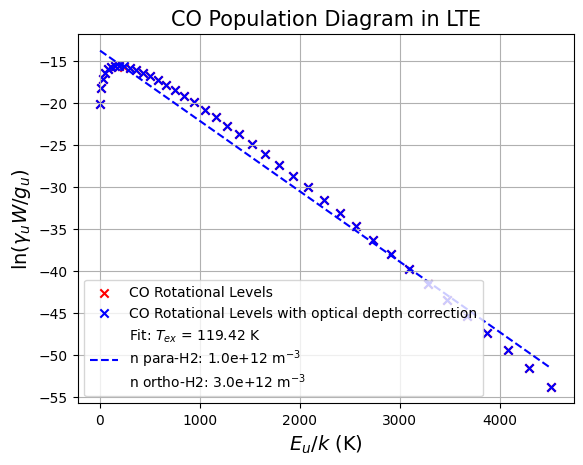

In [ ]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(Eu_co, y_values, marker="x", color="red", label="CO Rotational Levels")
plt.scatter(Eu_co, y_values_corrected, marker="x", color="blue", label="CO Rotational Levels with optical depth correction")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(Eu_co, y_values, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(Eu_co), max(Eu_co), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {collider_densities_LTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_LTE['ortho-H2']:.1e} m$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

# Line profile of CO


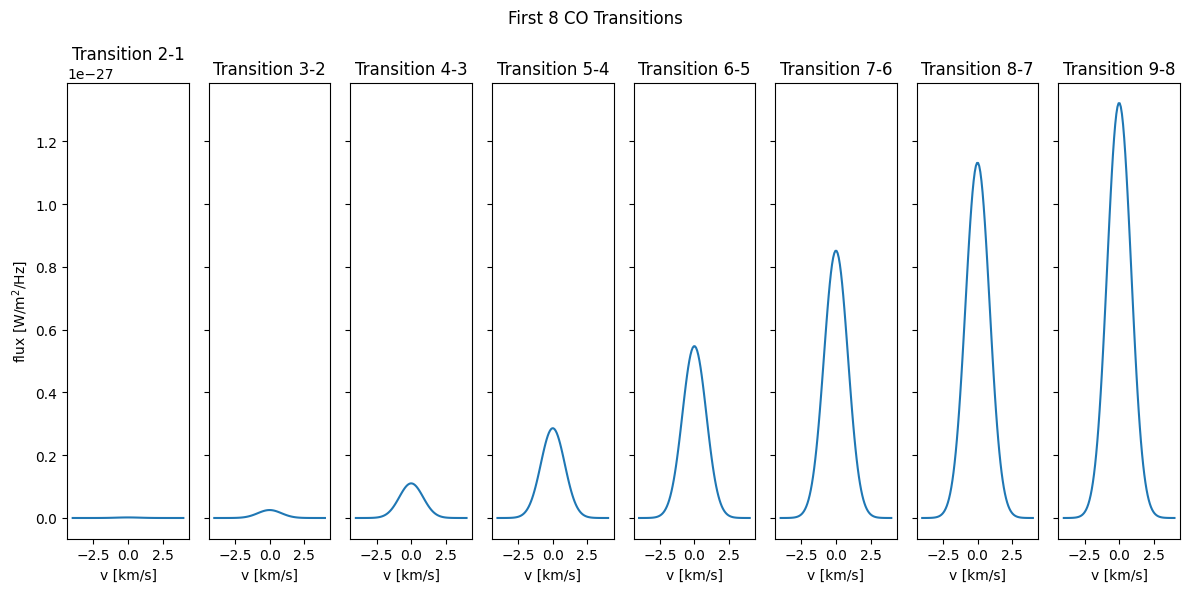

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = cloud.emitting_molecule.nu0[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# Plot CO population diagram for non-LTE case

In [ ]:
# update the clud using low densities of h2
collider_densities_nonLTE = {
    "para-H2": 2e2 / constants.centi**3,
    "ortho-H2": 6e2 / constants.centi**3,
}

N = 1e16 / constants.centi**2  # CO column density in m-2
Tkin = 120  # kinetic temperature in [K]
# collider densities in m-3:

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [ ]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      56.23       0.166985       0.454013       0.111165
   2    1     230.538000      11.20       0.454013       0.281867        1.34847
   3    2     345.795990      10.12       0.281867      0.0765565       0.967217
   4    3     461.040768      11.97      0.0765565      0.0155116       0.261017
   5    4     576.267931      16.86      0.0155116     0.00367598      0.0491021
   6    5     691.473076      22.56     0.00367598    0.000997868      0.0108925
   7    6     806.651806      27.43    0.000997868    0.000280757     0.00285835
   8    7     921.799700      32.18    0.000280757     8.0462e-05    0.000784673
   9    8    1036.912393      36.21     8.0462e-05    2.27524e-05    0.000222408
  10    9    1151.985452      40.16    2.27524e-05    6.34715e-06    6.22991e-05
  11   10    1267.014486      44.12    6.34715e-06    1.75215e-06    1.72368e-05
  12   11    1381.995105   

In [ ]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

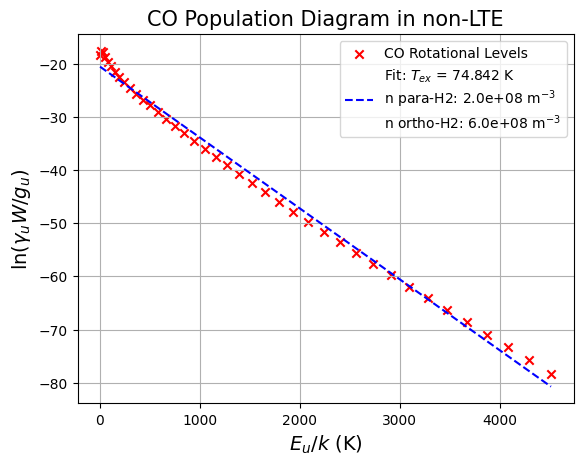

In [ ]:
# get the new non-lte y values: ln(γ_u * W / g_u)
y_values_nonLTE = np.log(gamma_factor * flux_nonLTE / np.array([level.g for level in levels_inJoules_co])[1:])

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(Eu_co, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(Eu_co, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(Eu_co), max(Eu_co), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(f"Fit: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {collider_densities_nonLTE['para-H2']:.1e} m$^{{-3}}$\nn ortho-H2: {collider_densities_nonLTE['ortho-H2']:.1e} m$^{{-3}}$"),
)
plt.legend()
ax.grid()
plt.show()

In [ ]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 74.842 K
Kinetic temperature of the cloud: 120 K


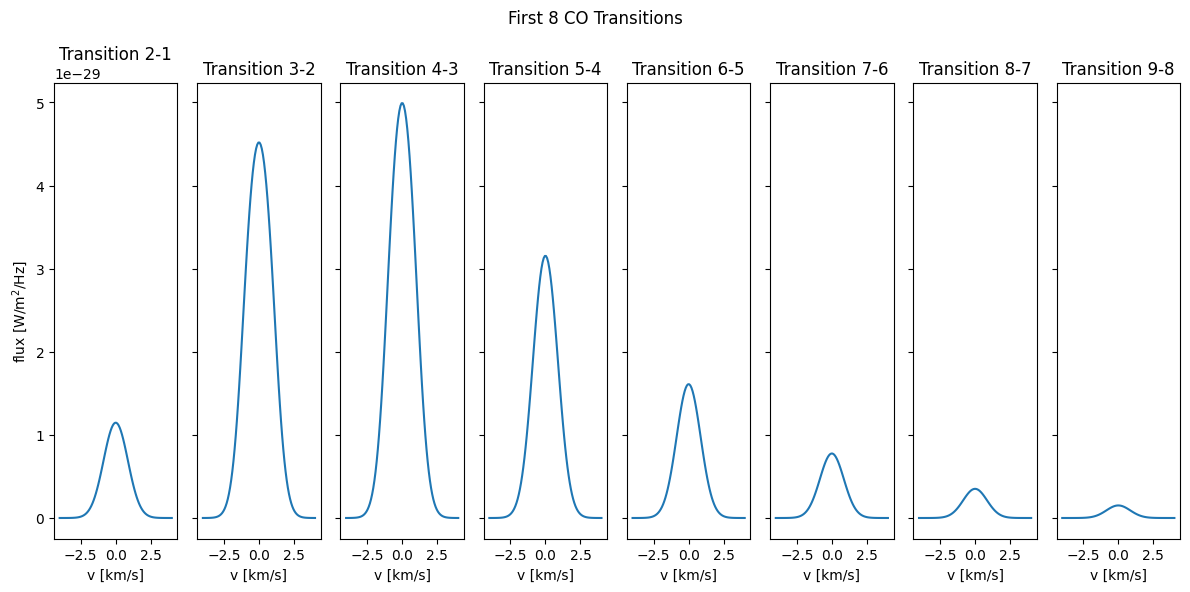

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = cloud.emitting_molecule.nu0[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# Plot population diagram for CH3OH-e

In [ ]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot = 1e16 / constants.centi**2  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e16 / constants.centi**2  # CH3OH_e column density in m-2
Tkin = 120  # kinetic temperature in [K]

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e5 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.011
14-13: tau_nu0 = -4.36e-05
46-45: tau_nu0 = -2.74
28-27: tau_nu0 = -0.000572
42-40: tau_nu0 = -4.83e-15
26-24: tau_nu0 = -0.000192
91-89: tau_nu0 = -1.47e-05
10-8: tau_nu0 = -0.0438
79-77: tau_nu0 = -0.00614
92-91: tau_nu0 = -0.00896
105-104: tau_nu0 = -0.00475
121-120: tau_nu0 = -0.00392
14-12: tau_nu0 = -1.89
68-66: tau_nu0 = -5.23e-06
139-137: tau_nu0 = -3.83e-05
9-7: tau_nu0 = -11.7
38-37: tau_nu0 = -0.00665
86-85: tau_nu0 = -0.000467
12-11: tau_nu0 = -2.62e-05
3-2: tau_nu0 = -0.00819
19-18: tau_nu0 = -9.31e-05
92-89: tau_nu0 = -0.00639
59-56: tau_nu0 = -1.11
38-36: tau_nu0 = -0.000578
13-11: tau_nu0 = -3.87e-08
35-34: tau_nu0 = -4.96e-16
33-31: tau_nu0 = -0.000229
104-103: tau_nu0 = -6.97e-06
19-17: tau_nu0 = -2.08
80-78: tau_nu0 = -4.25e-06
16-14: tau_nu0 = -11.7
46-44: tau_nu0 = -0.00707
75-73: tau_nu0 = -0.000521
17-15: tau_nu0 = -0.000107
8-6: tau_nu0 = -0.0229
26-23: tau_nu0 = -0.000153
105-103: tau_nu0 = -0.00298
69-68: tau_nu0 = -0.411
164-162: tau_n

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [ ]:
# flux can only computed for non overlapyng line, hance the below is commented for now, find a solution!
# possible solution: look at Overlapping lines in pythonradex documentation

# # calculate the flux recorded by the telescope
# # define the telescope parameters
# d_observer = 100 * constants.parsec  # distance to the observer in m
# source_radius = 10 * constants.au  # radius of the source in m
# source_solid_angle = source_radius**2 * np.pi / d_observer**2  # solid angle of the source

# # calculate the observed fluxes [W/m2], outputed as a list
# flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# # convert flux to np.array
# flux_methanol = np.array(flux_methanol)

In [ ]:
print(cloud_metahnol.emitting_molecule.coll_transitions.keys())

dict_keys(['H2'])


# Don't read the below code, it is for testing


In [ ]:
# calculate partition function, missing B facto
z_partitionfunc = T_ex * constants.k / constants.h
# calculate the column density of CO

In [ ]:
# Constants
h = constants.h  # Planck's constant [J·s]
c = constants.c  # Speed of light [m/s]
amu_to_kg = constants.atomic_mass  # Conversion from amu to kg

# CO molecular data
m_C = 12.0 * amu_to_kg  # Carbon mass [kg]
m_O = 16.0 * amu_to_kg  # Oxygen mass [kg]
mu = (m_C * m_O) / (m_C + m_O)  # Reduced mass [kg]
r_e = 1.128e-10  # Bond length [m]

# Moment of inertia
I = mu * r_e**2  # kg·m²

# Rotational constant in Hz
B_Hz = h / (8 * (constants.pi**2) * I * c)

# Convert to cm⁻¹ (common unit in spectroscopy)
B_cm1 = B_Hz / (c * 100)

print(f"Rotational constant B for CO: {B_cm1:.4f} cm⁻¹")

Rotational constant B for CO: 0.0000 cm⁻¹
